In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xzvf '/content/drive/My Drive/DL Project/Datasets/TestData/test.tar.gz'
!cp '/content/drive/My Drive/DL Project/Model & Weights/Weights/resmodel_weights.h5' '/content'
!cp '/content/drive/My Drive/DL Project/Model & Weights/Weights/transmodel_weights.h5' '/content'

tar (child): /content/drive/My Drive/DL Project/Datasets/TestData/test.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
cp: cannot stat '/content/drive/My Drive/DL Project/Model & Weights/Weights/resmodel_weights.h5': No such file or directory
cp: cannot stat '/content/drive/My Drive/DL Project/Model & Weights/Weights/transmodel_weights.h5': No such file or directory


In [ ]:
import numpy as np
import h5py
import math


from keras.models import Model
from keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv3D
from keras.layers import Lambda, Concatenate, MaxPooling2D, Maximum, Add
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import schedules, SGD
from keras.callbacks import Callback
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image

import cv2

%matplotlib inline

In [ ]:
def Guidedfilter(im,p,r,eps):
	mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r))
	mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r))
	mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r))
	cov_Ip = mean_Ip - mean_I*mean_p
	mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r))
	var_I   = mean_II - mean_I*mean_I
	a = cov_Ip/(var_I + eps)
	b = mean_p - a*mean_I
	mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r))
	mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r))
	q = mean_a*im + mean_b
	return q

def TransmissionRefine(im,et):
	gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
	gray = np.float64(gray)/255
	r = 60
	eps = 0.0001
	t = Guidedfilter(gray,et,r,eps)
	return t

In [ ]:
def TransmissionModel(input_shape):

    X_input = Input(input_shape, name = 'input1')

    # CONV -> RELU Block applied to X
    X = Conv2D(16, (3, 3), strides = (1, 1), name = 'conv1')(X_input)
    X = Activation('relu', name = 'activation1')(X)

    # SLICE Block applied to X
    X1 = Lambda(lambda X: X[:,:,:,:4], name = 'slice1')(X)
    X2 = Lambda(lambda X: X[:,:,:,4:8], name = 'slice2')(X)
    X3 = Lambda(lambda X: X[:,:,:,8:12], name = 'slice3')(X)
    X4 = Lambda(lambda X: X[:,:,:,12:], name = 'slice4')(X)

    # MAXIMUM Block applied to 4 slices
    X = Maximum(name = 'merge1_maximum')([X1,X2,X3,X4])

    # CONV BLock for multi-scale mapping with filters of size 3x3, 5x5, 7x7
    X_3x3 = Conv2D(16, (3, 3), strides = (1, 1), padding = 'same', name = 'conv2_3x3')(X)
    X_5x5 = Conv2D(16, (5, 5), strides = (1, 1), padding = 'same', name = 'conv2_5x5')(X)
    X_7x7 = Conv2D(16, (7, 7), strides = (1, 1), padding = 'same', name = 'conv2_7x7')(X)

    # CONCATENATE Block to join 3 multi-scale layers
    X = Concatenate(name = 'merge2_concatenate')([X_3x3,X_5x5,X_7x7])

    # MAXPOOL layer of filter size 7x7
    X = MaxPooling2D((7, 7), strides = (1, 1), name = 'maxpool1')(X)

    # CONV -> RELU BLock
    X = Conv2D(1, (8, 8), strides = (1, 1), name = 'conv3')(X)
    X = Activation('relu', name = 'activation2')(X)

    # Create Keras model instance
    model = Model(inputs = X_input, outputs = X, name='TransmissionModel')

    return model

In [ ]:
def ResidualBlock(X, iter):

    # Save the input value
    X_shortcut = X

    # BATCHNORMALIZATION -> CONV Block
    X = BatchNormalization(axis = 3, name = 'res_batchnorm' + str(iter))(X)
    X = Conv2D(1, (3, 3), strides = (1,1), padding = 'same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.001), name = 'res_conv' + str(iter))(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add(name = 'res_add'+ str(iter))([X,X_shortcut])
    X = Activation('relu', name = 'res_activation'+ str(iter))(X)

    return X

def ResidualModel(input_shape):

    X_input = Input(input_shape, name = 'input1')

    # CONV -> RELU Block applied to X
    X = Conv2D(16, (3, 3), strides = (1, 1), padding = 'same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.001), name = 'conv1')(X_input)
    X = Activation('relu', name = 'activation1')(X)

    for i in range(17):
        X = ResidualBlock(X, i)

    # CONV BLock
    X = Conv2D(3, (3, 3), strides = (1, 1), padding = 'same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.001), name = 'conv2')(X)
    X = Activation('relu', name = 'activation2')(X)

    # Create Keras model instance
    model = Model(inputs = X_input, outputs = X, name='TransmissionModel')

    return model

In [ ]:
def dehaze_image(img_name):
    input_image_orig = np.asarray(Image.open(img_name))/255.0
    input_image = np.pad(input_image_orig,((7,8), (7,8), (0,0)),'symmetric')

    model = TransmissionModel(input_image.shape)
    model.load_weights('transmodel_weights.h5')

    input_image = np.expand_dims(input_image, axis=0)
    trans_map_orig = model.predict(input_image)
    trans_map = trans_map_orig.reshape(input_image_orig.shape[:2])
    trans_map_refine = TransmissionRefine((input_image_orig*255.0).astype('uint8'),trans_map)

    res_map_input = input_image_orig/np.expand_dims(trans_map_refine, axis=(0,3))

    model = ResidualModel(res_map_input.shape[1:])
    model.load_weights('resmodel_weights.h5')
    res_map_output = model.predict(np.clip(res_map_input,0,1))

    haze_free_image = (res_map_input-res_map_output)
    haze_free_image = np.clip(haze_free_image,0,1)

    return haze_free_image[0]

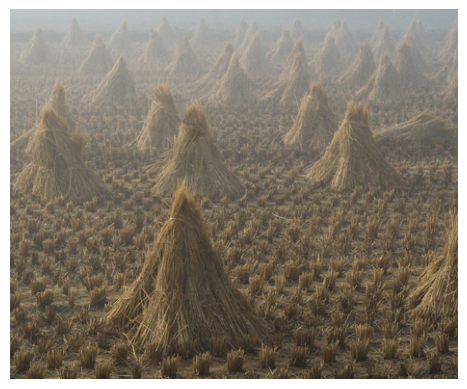

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def dehaze_image(image_path):
    # Load image
    img = Image.open(image_path)

    # Convert image to numpy array
    img_array = np.array(img)

    # Perform simple dehazing operation
    # This is a placeholder for a real dehazing algorithm
    # Here, we will just multiply the image by 0.7 to make it slightly darker
    out_img = img_array

    return out_img

# Now you can use dehaze_image function
image_path = '/content/drive/MyDrive/Image-Dehazing-Using-Residual-Based-Deep-CNN-master/Image-Dehazing-Using-Residual-Based-Deep-CNN-master/Results/other/cones.jpg'
out = dehaze_image(image_path)

# Display the dehazed image
plt.imshow(out)
plt.axis('off')
plt.show()


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image  # Assuming dehaze_image uses PIL to open images

def dehaze_image(image_path):
    # Placeholder function for dehazing an image
    # Replace this with your actual dehazing function
    return Image.open(image_path)

input_dir = '/content/drive/MyDrive/Image-Dehazing-Using-Residual-Based-Deep-CNN-master/Image-Dehazing-Using-Residual-Based-Deep-CNN-master/Results/out/'
output_dir = 'out_output/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(20):
    input_path = os.path.join(input_dir, f'{i}.jpg')
    output_path = os.path.join(output_dir, f'{i}_dehaze.png')

    if os.path.exists(input_path):
        out = dehaze_image(input_path)
        plt.imsave(output_path, out)
    else:
        print(f"File not found: {input_path}")


In [ ]:
!tar -cvf out_output.tar.gz out_output

out_output/
out_output/9_dehaze.png
out_output/11_dehaze.png
out_output/7_dehaze.png
out_output/6_dehaze.png
out_output/1_dehaze.png
out_output/8_dehaze.png
out_output/18_dehaze.png
out_output/5_dehaze.png
out_output/2_dehaze.png
out_output/3_dehaze.png
out_output/14_dehaze.png
out_output/13_dehaze.png
out_output/0_dehaze.png
out_output/12_dehaze.png
out_output/16_dehaze.png
out_output/15_dehaze.png
out_output/10_dehaze.png
out_output/17_dehaze.png
out_output/19_dehaze.png
out_output/4_dehaze.png


In [ ]:
input_image_orig = np.asarray(Image.open('/content/drive/MyDrive/Image-Dehazing-Using-Residual-Based-Deep-CNN-master/Image-Dehazing-Using-Residual-Based-Deep-CNN-master/Results/out/6.jpg'))/255.0
input_image = np.pad(input_image_orig,((7,8), (7,8), (0,0)),'symmetric')

In [ ]:
model = TransmissionModel(input_image.shape)
# model.summary()
model.load_weights('/content/drive/MyDrive/Image-Dehazing-Using-Residual-Based-Deep-CNN-master/Image-Dehazing-Using-Residual-Based-Deep-CNN-master/Model and Weights/Weights/transmodel_weights.h5')

input_image = np.expand_dims(input_image, axis=0)
trans_map_orig = model.predict(input_image)
trans_map = trans_map_orig.reshape(input_image_orig.shape[:2])
trans_map_refine = TransmissionRefine((input_image_orig*255.0).astype('uint8'),trans_map)

1/1 [==============================] - 1s 1s/step


In [ ]:
res_map_input = input_image_orig/np.expand_dims(trans_map_refine, axis=(0,3))

In [ ]:
model = ResidualModel(res_map_input.shape[1:])
model.load_weights('/content/drive/MyDrive/Image-Dehazing-Using-Residual-Based-Deep-CNN-master/Image-Dehazing-Using-Residual-Based-Deep-CNN-master/Model and Weights/Weights/resmodel_weights.h5')
res_map_output = model.predict(np.clip(res_map_input,0,1))

1/1 [==============================] - 1s 1s/step


In [ ]:
haze_free_image = (res_map_input-res_map_output)
haze_free_image = np.clip(haze_free_image,0,1)

Input Image


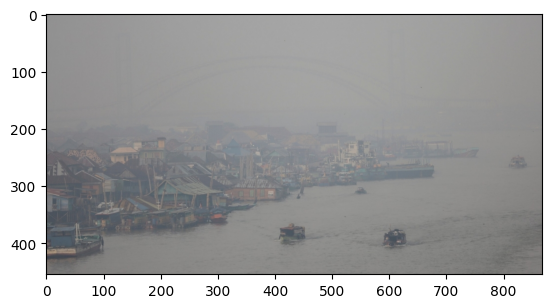

Transmission Map


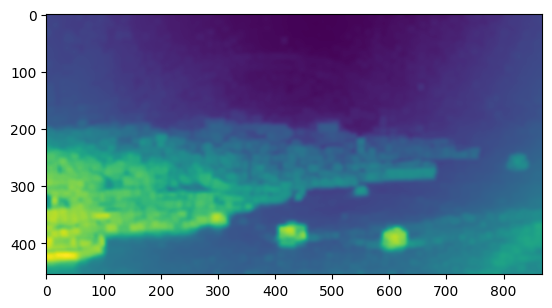

Refined Transmission Map


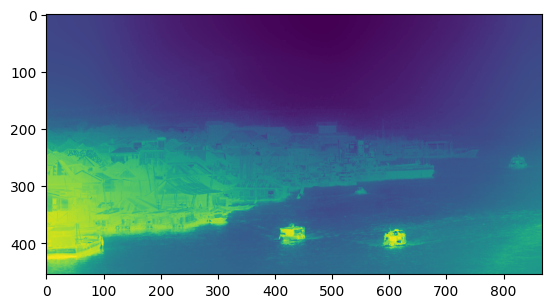

Residual Model Input Image


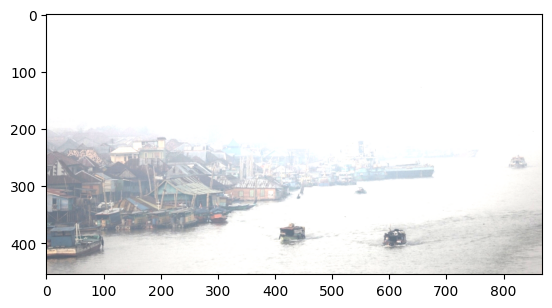

Residual Model Output Image


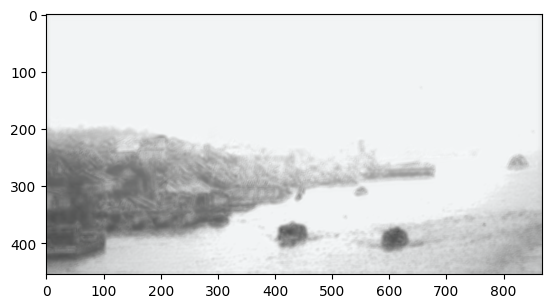

Generated Haze Free Image


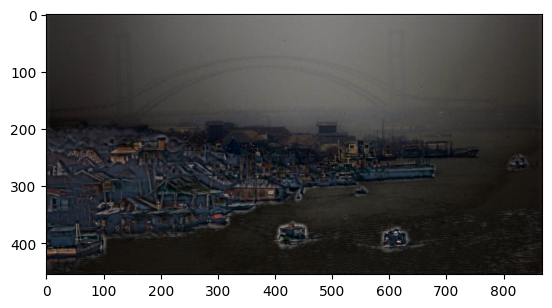

In [ ]:
print('Input Image')
plt.imshow(input_image_orig)
plt.show()

print('Transmission Map')
plt.imshow(trans_map)
plt.show()

print('Refined Transmission Map')
plt.imshow(trans_map_refine)
plt.show()

print('Residual Model Input Image')
plt.imshow(np.clip(res_map_input[0],0,1))
plt.show()

print('Residual Model Output Image')
plt.imshow(np.clip(res_map_output[0],0,1))
plt.show()

print('Generated Haze Free Image')
plt.imshow(haze_free_image[0])
plt.show()

In [ ]:
plt.imsave('trans.png',trans_map)
plt.imsave('trans_refine.png',trans_map_refine)
plt.imsave('res_in.png',np.clip(res_map_input[0],0,1))
plt.imsave('res_out.png',np.clip(res_map_output[0],0,1))
plt.imsave('dehazed.jpg',np.clip(haze_free_image[0],0,1))

NameError: name 'plt' is not defined